In [438]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [465]:
runs = pd.read_csv('new_strava_data/activities.csv')

runs['Activity Date'] = pd.to_datetime(runs['Activity Date'], format='%b %d, %Y, %I:%M:%S %p')

rel_cols = [
    'Activity Date',
    'Elapsed Time',
    'Distance',
    'Moving Time',
    'Average Heart Rate',
    'Average Speed',
    'Elevation Gain',
    'Average Grade',
    'Grade Adjusted Distance',
]

recent_selector = runs['Activity Date'] > '2024-01-01'

runs_sub = runs[recent_selector][rel_cols]

# Only use rows with HR data
runs_sub = runs_sub[~pd.isna(runs_sub['Average Heart Rate'])]

runs_sub = runs_sub.sort_values('Activity Date')

# Remove outliers

In [466]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Apply to both heart rate and speed
runs_sub = remove_outliers_iqr(runs_sub, 'Average Heart Rate')
runs_sub = remove_outliers_iqr(runs_sub, 'Average Speed')

# Remove elevation outliers
runs_sub = runs_sub[runs_sub['Elevation Gain'] < 100]

# Control for speed + elevation

In [467]:
import statsmodels.api as sm

X = runs_sub[['Average Speed', 'Average Grade']]
y = runs_sub['Average Heart Rate']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

runs_sub['hr_corrected'] = model.resid

In [468]:
runs_sub['hr_moving_average'] = runs_sub['hr_corrected'].rolling(window=10).mean()

runs_sub = runs_sub[10:] # Ignore initial nans

# Linear Trend

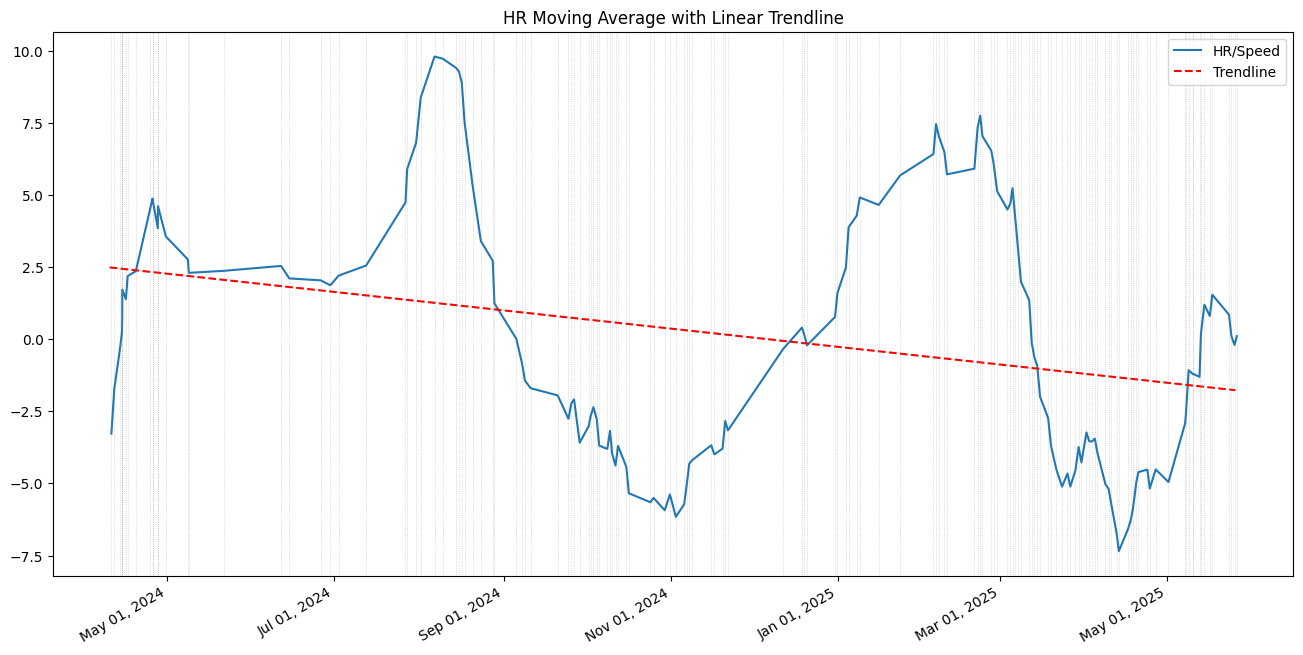

In [480]:
import matplotlib.dates as mdates

# Create a larger figure
fig, ax = plt.subplots(figsize=(16, 8))  # Width = 16 inches, Height = 8 inches

# Main line plot
ax.plot(runs_sub['Activity Date'], runs_sub['hr_moving_average'], label='HR/Speed')

x = runs_sub['Activity Date']
y = runs_sub['hr_moving_average']
x_numeric = x.map(datetime.toordinal)

# Fit linear trendline
z = np.polyfit(x_numeric, y, 1)
p = np.poly1d(z)

# Convert ordinal dates to matplotlib's float format
trendline_x = mdates.date2num([datetime.fromordinal(int(val)) for val in x_numeric])
trendline_y = p(x_numeric)

# Plot the trendline using float dates (no warning)
ax.plot(trendline_x, trendline_y, color='red', linestyle='--', label='Trendline')

# Add small vertical tick marks for each run
for run_date in runs_sub['Activity Date']:
    ax.axvline(run_date, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

# Format x-axis to show dates nicely
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
ax.figure.autofmt_xdate()  # Auto rotates date labels

ax.legend()
ax.set_title('HR Moving Average with Linear Trendline')

plt.show()

In [470]:
slope = z[0]
intercept = z[1]

print(f"Slope: {slope:.6f} bpm per unit speed per day")
print(f"Intercept: {intercept:.3f} bpm per unit speed")

if slope < 0:
    print("Heart rate per unit speed is decreasing over time — indicating improving cardiovascular efficiency.")
elif slope > 0:
    print("Heart rate per unit speed is increasing over time — indicating increasing effort or fatigue.")
else:
    print("No clear trend in heart rate per unit speed over time.")

Slope: -0.010357 bpm per unit speed per day
Intercept: 7656.202 bpm per unit speed
Heart rate per unit speed is decreasing over time — indicating improving cardiovascular efficiency.


In [471]:
days_span = (runs_sub['Activity Date'].max() - runs_sub['Activity Date'].min()).days
days_span

410

In [472]:
total_decrease = slope * days_span  # slope is negative, so this will be negative
total_decrease

np.float64(-4.24638843829691)

In [473]:
print(f"Over {days_span} days, your heart rate per unit speed decreased by {abs(total_decrease):.3f} bpm per unit speed.")

Over 410 days, your heart rate per unit speed decreased by 4.246 bpm per unit speed.


In [474]:
# HR decrease = slope decrease (bpm per unit speed) × speed (mph)

p_s = [('7:30', 8.0), ('8:00', 7.5), ('9:00', 6.67)]

for p, s in p_s:
    hr_decrease = total_decrease * s
    print(f"HR improved {hr_decrease:.0f} bpm at {p} pace")

HR improved -34 bpm at 7:30 pace
HR improved -32 bpm at 8:00 pace
HR improved -28 bpm at 9:00 pace


# LOESS

/var/folders/dx/sggrdnfn5mqgszgsy2l049dr0000gn/T/ipykernel_20282/4288813100.py:9: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(trendline_x, trendline_y, color='green', linestyle='-', label='LOESS Smoother')


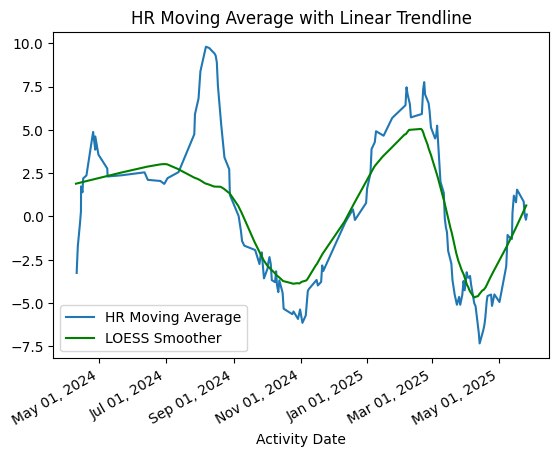

In [475]:
ax = runs_sub.plot.line(x='Activity Date', y='hr_moving_average', rot=45, label='HR Moving Average')

lowess = sm.nonparametric.lowess
smoothed = lowess(y, x_numeric, frac=0.3)  # frac controls smoothness

trendline_x = [datetime.fromordinal(int(d)) for d in smoothed[:, 0]]
trendline_y = smoothed[:, 1]

ax.plot(trendline_x, trendline_y, color='green', linestyle='-', label='LOESS Smoother')

# Format x-axis to show dates nicely
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
ax.figure.autofmt_xdate()  # Auto rotates date labels

ax.legend()
ax.set_title('HR Moving Average with Linear Trendline')

plt.show()

In [476]:
# Extract the starting and ending heart rate per unit speed
start_hr = smoothed[0, 1]        # First y-value from LOESS output
end_hr = smoothed[-1, 1]         # Last y-value

# Difference in heart rate per unit speed over the date range
delta_hr_per_speed = end_hr - start_hr

# Translate to actual heart rate change at specific speeds (in m/s)
# 7:30 min/mi ≈ 3.56 m/s
# 8:00 min/mi ≈ 3.35 m/s
# 9:00 min/mi ≈ 2.98 m/s

paces = {
    "7:30 min/mi": 3.56,
    "8:00 min/mi": 3.35,
    "9:00 min/mi": 2.98
}

for label, speed in paces.items():
    hr_change = delta_hr_per_speed * speed
    print(f"At {label}, HR decreased by approximately {hr_change:.2f} bpm")

At 7:30 min/mi, HR decreased by approximately -4.47 bpm
At 8:00 min/mi, HR decreased by approximately -4.21 bpm
At 9:00 min/mi, HR decreased by approximately -3.74 bpm
